<a href="https://colab.research.google.com/github/Gabriel-barbosa-silva/Projeto_de_Transfer_Learning_em_Python/blob/main/projeto__de_transfer__learning_em_python__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto de Transfer Learning em Python**
O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.

In [ ]:
# Importar bibliotecas essenciais
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 # Exemplo de modelo pré-treinado
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from google.colab import drive, files

# --- Montar Google Drive ---
# Isso permitirá que você salve e acesse seus dados e modelos no seu Drive.
print("Montando Google Drive...")
drive.mount('/content/drive')
print("Google Drive montado com sucesso!")

# Definir o caminho base do seu projeto no Google Drive
# Crie uma pasta 'MeuProjeto_TL' no seu Google Drive (manualmente ou via código)
# e esta será a raiz do seu projeto.
project_base_dir = '/content/drive/MyDrive/MeuProjeto_TL'
os.makedirs(project_base_dir, exist_ok=True)
print(f"Diretório base do projeto: {project_base_dir}")

# Definir os diretórios para dados (dentro do seu projeto no Drive)
data_dir = os.path.join(project_base_dir, 'dataset_animais')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')
raw_images_temp_dir = os.path.join(data_dir, 'raw_temp_upload') # Pasta temporária para upload inicial

# Criar as estruturas de pastas necessárias
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(raw_images_temp_dir, exist_ok=True) # Cria a pasta temporária de upload

print(f"\nEstrutura de pastas para dados criada em: {data_dir}")
print(f"  - Treino: {train_dir}")
print(f"  - Validação: {validation_dir}")
print(f"  - Teste: {test_dir}")
print(f"  - Upload Temporário: {raw_images_temp_dir}")

Montando Google Drive...
Mounted at /content/drive
Google Drive montado com sucesso!
Diretório base do projeto: /content/drive/MyDrive/MeuProjeto_TL

Estrutura de pastas para dados criada em: /content/drive/MyDrive/MeuProjeto_TL/dataset_animais
  - Treino: /content/drive/MyDrive/MeuProjeto_TL/dataset_animais/train
  - Validação: /content/drive/MyDrive/MeuProjeto_TL/dataset_animais/validation
  - Teste: /content/drive/MyDrive/MeuProjeto_TL/dataset_animais/test
  - Upload Temporário: /content/drive/MyDrive/MeuProjeto_TL/dataset_animais/raw_temp_upload


In [ ]:
print(f"Fazendo upload das imagens para '{raw_images_temp_dir}'...")
print("Por favor, selecione todas as suas imagens de leão e urso para upload.")

uploaded = files.upload() # Abre a caixa de diálogo para selecionar arquivos

# Mover os arquivos carregados para a pasta temporária no Drive
for filename in uploaded.keys():
    # O arquivo uploaded está na raiz da sessão Colab (/content/)
    src_path = os.path.join('/content/', filename)
    dest_path = os.path.join(raw_images_temp_dir, filename)
    shutil.move(src_path, dest_path)
    print(f"  Movido '{filename}' para '{raw_images_temp_dir}'")

print(f"\nUpload concluído. Total de arquivos carregados e movidos: {len(uploaded)}")
print(f"Conteúdo de '{raw_images_temp_dir}' (primeiros 5 arquivos):")
if os.listdir(raw_images_temp_dir):
    for f in os.listdir(raw_images_temp_dir)[:5]:
        print(f"- {f}")
    if len(os.listdir(raw_images_temp_dir)) > 5:
        print(f"... e mais {len(os.listdir(raw_images_temp_dir)) - 5} arquivos.")
else:
    print("Nenhum arquivo encontrado. Certifique-se de ter feito o upload.")

Fazendo upload das imagens para '/content/drive/MyDrive/MeuProjeto_TL/dataset_animais/raw_temp_upload'...
Por favor, selecione todas as suas imagens de leão e urso para upload.


Saving leao (1).jpg to leao (1).jpg
Saving leao (2).jpg to leao (2).jpg
Saving leao (3).jpg to leao (3).jpg
Saving leao (4).jpg to leao (4).jpg
Saving leao (5).jpg to leao (5).jpg
Saving leao (6).jpg to leao (6).jpg
Saving leao (7).jpg to leao (7).jpg
Saving leao (8).jpg to leao (8).jpg
Saving leao (9).jpg to leao (9).jpg
Saving leao (10).jpg to leao (10).jpg
Saving leao (11).jpg to leao (11).jpg
Saving leao (12).jpg to leao (12).jpg
Saving leao (13).jpg to leao (13).jpg
Saving leao (14).jpg to leao (14).jpg
Saving leao (15).jpg to leao (15).jpg
Saving leao (16).jpg to leao (16).jpg
Saving leao (17).jpg to leao (17).jpg
Saving leao (18).jpg to leao (18).jpg
Saving leao (19).jpg to leao (19).jpg
Saving leao (20).jpg to leao (20).jpg
Saving leao (21).jpg to leao (21).jpg
Saving leao (22).jpg to leao (22).jpg
Saving leao (23).jpg to leao (23).jpg
Saving leao (24).jpg to leao (24).jpg
Saving leao (25).jpg to leao (25).jpg
Saving leao (26).jpg to leao (26).jpg
Saving leao (27).jpg to leao (

In [ ]:
# --- Função para determinar a classe do arquivo ---
# Esta função é essencial. Ela precisa ser capaz de identificar se o arquivo
# é de 'leao' ou 'urso' baseado no nome do arquivo.
def get_class_from_filename(filename):
    # Liste todas as suas classes esperadas aqui.
    # Os nomes devem corresponder às pastas que você quer criar (ex: 'leao', 'urso').
    known_classes = ['leao', 'urso'] # Adapte se tiver mais classes!

    filename_lower = filename.lower()

    for class_name in known_classes:
        if class_name in filename_lower:
            return class_name # Retorna a primeira classe que encontrar no nome do arquivo

    return 'desconhecida' # Retorna 'desconhecida' se a classe não puder ser identificada

# Teste a função com exemplos (AJUSTE CONFORME OS NOMES REAIS DOS SEUS ARQUIVOS!)
print("\n--- Testando a função 'get_class_from_filename' ---")
print(f"'minha_foto_leao_01.jpg' -> {get_class_from_filename('minha_foto_leao_01.jpg')}")
print(f"'urso_polar_grande.png' -> {get_class_from_filename('urso_polar_grande.png')}")
print(f"'algum_animal_desconhecido.jpeg' -> {get_class_from_filename('algum_animal_desconhecido.jpeg')}")
print(f"'leao_marinho.jpg' -> {get_class_from_filename('leao_marinho.jpg')}") # CUIDADO se 'leao_marinho' for uma classe separada!
print("--- Fim do Teste ---")

# --- Coletar todos os caminhos das imagens da pasta temporária ---
all_image_files = []
for root, _, files in os.walk(raw_images_temp_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')):
            all_image_files.append(os.path.join(root, file))

image_paths_with_classes = {}
for img_path in all_image_files:
    filename = os.path.basename(img_path)
    class_name = get_class_from_filename(filename)
    if class_name != 'desconhecida':
        image_paths_with_classes[img_path] = class_name
    else:
        print(f"Aviso: Não foi possível determinar a classe para '{filename}'. Ignorando.")

if not image_paths_with_classes:
    raise ValueError("Nenhuma imagem com classe reconhecível encontrada. Verifique os nomes dos arquivos e a função 'get_class_from_filename'.")

# --- Dividir os dados em Treino, Validação e Teste ---
# 70% Treino, 15% Validação, 15% Teste
image_paths = list(image_paths_with_classes.keys())
labels = [image_paths_with_classes[p] for p in image_paths]

# Primeiro, dividimos em treino e (validação + teste)
train_paths, val_test_paths, _, val_test_labels = train_test_split(
    image_paths, labels,
    test_size=0.30, # 30% para validação + teste
    stratify=labels,
    random_state=42 # Para reprodutibilidade
)

# Depois, dividimos (validação + teste) em validação e teste
val_paths, test_paths = train_test_split(
    val_test_paths,
    test_size=0.5, # 50% do restante, que resulta em 15% do total para cada um
    stratify=val_test_labels,
    random_state=42
)

print(f"\n--- Resumo da Divisão de Dados ---")
print(f"Total de imagens carregadas: {len(image_paths)}")
print(f"Imagens para treino: {len(train_paths)}")
print(f"Imagens para validação: {len(val_paths)}")
print(f"Imagens para teste: {len(test_paths)}")

# --- Mover os arquivos para as pastas finais (no Drive) ---
print("\nMovendo imagens para as pastas de treino, validação e teste no Google Drive...")
for path_list, target_dir in [(train_paths, train_dir), (val_paths, validation_dir), (test_paths, test_dir)]:
    for img_path in path_list:
        class_name = image_paths_with_classes[img_path]
        dest_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True) # Garante que a pasta da classe exista

        # O shutil.move irá mover o arquivo do raw_images_temp_dir para o destino final no Drive
        shutil.move(img_path, os.path.join(dest_class_dir, os.path.basename(img_path)))
print("Arquivos organizados com sucesso!")

# --- Limpar a pasta temporária de upload após a organização ---
print(f"\nRemovendo pasta temporária de upload: {raw_images_temp_dir}")
shutil.rmtree(raw_images_temp_dir)
print("Pasta temporária removida.")

# --- Verificação Final das Pastas Organizadas ---
def verify_organized_dirs(base_path):
    print(f"\n--- Verificando Conteúdo em {base_path} ---")
    if not os.path.exists(base_path):
        print(f"Diretório '{base_path}' NÃO EXISTE.")
        return

    for split_dir_name in ['train', 'validation', 'test']:
        split_path = os.path.join(base_path, split_dir_name)
        print(f"\n  Conteúdo de {split_dir_name} ({split_path}):")
        if not os.path.exists(split_path):
            print(f"    Diretório '{split_path}' NÃO EXISTE.")
            continue

        class_folders = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        if not class_folders:
            print(f"    Nenhuma pasta de classe encontrada em '{split_path}'.")
            continue

        print(f"    Classes encontradas: {class_folders}")
        for class_folder in class_folders:
            class_path = os.path.join(split_path, class_folder)
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"      - {class_folder}: {num_images} imagens.")

verify_organized_dirs(data_dir)


--- Testando a função 'get_class_from_filename' ---
'minha_foto_leao_01.jpg' -> leao
'urso_polar_grande.png' -> urso
'algum_animal_desconhecido.jpeg' -> desconhecida
'leao_marinho.jpg' -> leao
--- Fim do Teste ---
Aviso: Não foi possível determinar a classe para 'drazen-vukcevic-ZYfPA9205hY-unsplash.jpg'. Ignorando.
Aviso: Não foi possível determinar a classe para 'charge-the-globe-R9EKDaV1oi4-unsplash (1).jpg'. Ignorando.
Aviso: Não foi possível determinar a classe para 'birger-strahl-5kbFvsYe4K4-unsplash.jpg'. Ignorando.
Aviso: Não foi possível determinar a classe para 'david-amritzer-romo-YimhMiPj6JI-unsplash.jpg'. Ignorando.
Aviso: Não foi possível determinar a classe para 'adam-gman-UUGYCRrrI7U-unsplash.jpg'. Ignorando.
Aviso: Não foi possível determinar a classe para 'florian-schindler-i-RQxlI4a1Y-unsplash.jpg'. Ignorando.
Aviso: Não foi possível determinar a classe para 'amanda-swanepoel-28msnzTRqt8-unsplash (1).jpg'. Ignorando.
Aviso: Não foi possível determinar a classe para 

In [ ]:
IMAGE_SIZE = (300, 300) # Tamanho padrão para VGG16
BATCH_SIZE = 32

# --- Função de Pré-processamento ---
# Para VGG16, use a função preprocess_input da Keras Applications.
# Se você estiver usando outro modelo, importe a função correspondente.
# Se não estiver usando um modelo pré-treinado, pode normalizar assim:
# def custom_preprocess_input(x):
#     return x / 255.0 # Normaliza os pixels para o intervalo [0, 1]

from tensorflow.keras.applications.vgg16 import preprocess_input # Importa para VGG16

# --- Criar Geradores de Dados ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Função de pré-processamento do modelo
    rotation_range=20, # Rotação aleatória de imagens
    width_shift_range=0.2, # Deslocamento horizontal aleatório
    height_shift_range=0.2, # Deslocamento vertical aleatório
    shear_range=0.2, # Cisalhamento aleatório
    zoom_range=0.2, # Zoom aleatório
    horizontal_flip=True, # Inversão horizontal aleatória
    fill_mode='nearest' # Como preencher pixels recém-introduzidos
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # Apenas pré-processa, sem aumento de dados para validação
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # Apenas pré-processa, sem aumento de dados para teste
)

print("\n--- Criando Geradores de Dados ---")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # 'binary' se você tiver apenas 2 classes (mas use 'categorical' se tiver one-hot encoding)
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Não embaralhar os dados de validação para manter a consistência
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Não embaralhar os dados de teste para avaliação justa
)

# Obter o número de classes detectadas pelos geradores (importante para a camada de saída do modelo)
num_classes = train_generator.num_classes
print(f"\nNúmero de classes identificadas pelos geradores: {num_classes}")
print("Mapeamento de classes:", train_generator.class_indices)

# Verificação final para garantir que os geradores encontraram imagens
print(f"\n--- Verificação de Amostras nos Geradores ---")
print(f"Amostras de Treino: {train_generator.samples}")
print(f"Amostras de Validação: {validation_generator.samples}")
print(f"Amostras de Teste: {test_generator.samples}")

if train_generator.samples == 0 or validation_generator.samples == 0 or test_generator.samples == 0:
    raise ValueError("ERRO: Um ou mais geradores de dados não encontraram nenhuma amostra. "
                     "Verifique se as imagens foram organizadas corretamente nas pastas de treino/validação/teste.")
else:
    print("\nGeradores de dados criados e prontos para uso!")


--- Criando Geradores de Dados ---
Found 175 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 38 images belonging to 2 classes.

Número de classes identificadas pelos geradores: 2
Mapeamento de classes: {'leao': 0, 'urso': 1}

--- Verificação de Amostras nos Geradores ---
Amostras de Treino: 175
Amostras de Validação: 37
Amostras de Teste: 38

Geradores de dados criados e prontos para uso!


In [ ]:
# --- Construir o Modelo com Transfer Learning (VGG16) ---
print("\n--- Construindo o Modelo ---")


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


for layer in base_model.layers:
    layer.trainable = False

# Adiciona novas camadas personalizadas (cabeça de classificação) no topo do modelo base
x = base_model.output
x = Flatten()(x) # Acha os recursos planos para a camada densa
x = Dense(256, activation='relu')(x) # Uma camada densa com 256 neurônios
x = Dropout(0.5)(x) # Uma camada de Dropout para ajudar a prevenir overfitting
predictions = Dense(num_classes, activation='softmax')(x) # Camada de saída com 'softmax' para classificação multi-classe

# Cria o modelo final combinando o modelo base e as novas camadas
model = Model(inputs=base_model.input, outputs=predictions)

model.summary() # Exibe um resumo da arquitetura do modelo

# --- Compilar o Modelo ---
print("\n--- Compilando o Modelo ---")

loss_function = CategoricalCrossentropy() # Para classificação multi-classe (neste caso, 2 classes)

model.compile(
    optimizer=Adam(learning_rate=0.0001), # Otimizador Adam com uma taxa de aprendizado inicial
    loss=loss_function, # Função de perda
    metrics=['accuracy'] # Métrica para monitorar
)

print("Modelo construído e compilado com sucesso!")



--- Construindo o Modelo ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,332,290 (96.64 MB)

 Trainable params: 10,617,602 (40.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


--- Compilando o Modelo ---
Modelo construído e compilado com sucesso!


In [ ]:
# --- Parâmetros de Treinamento ---
EPOCHS = 15
STEPS_PER_EPOCH = train_generator.samples // train_generator.batch_size
VALIDATION_STEPS = validation_generator.samples // validation_generator.batch_size

print(f"\n--- Iniciando o Treinamento do Modelo ---")
print(f"Treinando por {EPOCHS} épocas...")
print(f"Passos por época (treino): {STEPS_PER_EPOCH}")
print(f"Passos de validação: {VALIDATION_STEPS}")

# Certifique-se de que STEPS_PER_EPOCH e VALIDATION_STEPS não sejam zero!
if STEPS_PER_EPOCH == 0:
    print("AVISO: STEPS_PER_EPOCH é 0. Isso significa que o train_generator.samples é menor que o batch_size.")
    print("O treinamento pode não ocorrer como esperado ou pode falhar.")
if VALIDATION_STEPS == 0:
    print("AVISO: VALIDATION_STEPS é 0. Isso significa que o validation_generator.samples é menor que o batch_size.")
    print("A validação pode não ocorrer como esperado ou pode falhar.")

# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS
)

print("\nTreinamento concluído!")



--- Iniciando o Treinamento do Modelo ---
Treinando por 15 épocas...
Passos por época (treino): 5
Passos de validação: 1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 180s 35s/step - accuracy: 0.5922 - loss: 6.8839 - val_accuracy: 0.8750 - val_loss: 1.2071
Epoch 2/15
1/5 ━━━━━━━━━━━━━━━━━━━━ 1:33 23s/step - accuracy: 0.8438 - loss: 1.6548

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 15s/step - accuracy: 0.8438 - loss: 1.6548 - val_accuracy: 0.9062 - val_loss: 1.1634
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 174s 35s/step - accuracy: 0.8316 - loss: 2.0245 - val_accuracy: 0.9375 - val_loss: 1.3114
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 13s/step - accuracy: 0.8750 - loss: 2.4817 - val_accuracy: 0.9375 - val_loss: 1.3900
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 187s 35s/step - accuracy: 0.9255 - loss: 0.8305 - val_accuracy: 0.9062 - val_loss: 1.6768
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 18s/step - accuracy: 0.9333 - loss: 1.9458 - val_accuracy: 0.9375 - val_loss: 1.6815
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 207s 43s/step - accuracy: 0.9518 - loss: 0.4109 - val_accuracy: 0.9062 - val_loss: 1.7571
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.9688 - loss: 0.0569 - val_accuracy: 0.9375 - val_loss: 1.7238
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 263s 42s/step - accuracy: 0.9591 - loss: 0.6098 - val_accuracy: 0.9375 - val_loss: 1.6489
Epoch 10

In [ ]:
print("\n--- Avaliando o Modelo no Conjunto de Teste ---")
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Perda no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")


--- Avaliando o Modelo no Conjunto de Teste ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 1.0000 - loss: 3.4179e-05
Perda no conjunto de teste: 0.0000
Acurácia no conjunto de teste: 1.0000



--- Visualizando o Histórico de Treinamento ---


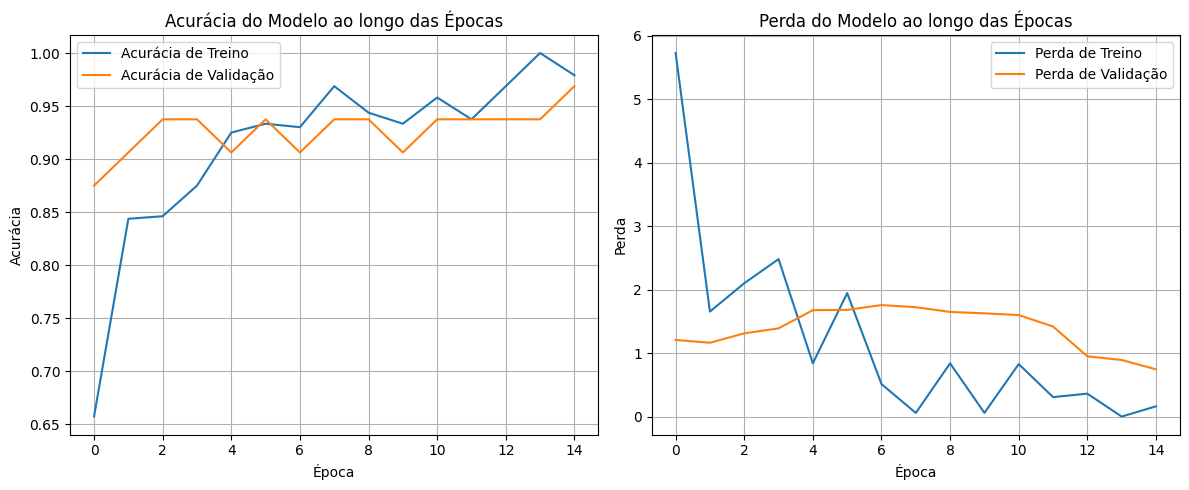

In [ ]:
print("\n--- Visualizando o Histórico de Treinamento ---")

# Plotar a acurácia de treinamento e validação
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo ao longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Plotar a perda de treinamento e validação
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo ao longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Salvar o modelo treinado para uso futuro
model_save_path = os.path.join(project_base_dir, 'leao_urso_classifier_model.h5')
model.save(model_save_path)
print(f"\nModelo salvo em: {model_save_path}")


Modelo salvo em: /content/drive/MyDrive/MeuProjeto_TL/leao_urso_classifier_model.h5
